# Stock prediction tool

**Available currencies:**

> **Bitcoin** - BTC-USD<br>
> **Ethereum** - ETH-USD<br>
> **BNB** - BNB-USD<br>
> **Dogecoin** - DOGE-USD<br>

In [51]:
import yfinance
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit, cross_val_score
from sklearn.metrics import make_scorer, r2_score, roc_auc_score, RocCurveDisplay, classification_report,\
                                confusion_matrix, ConfusionMatrixDisplay, precision_score
from sklearn.feature_selection import RFE

In [2]:
bitcoin = yfinance.Ticker("BTC-USD")
ethereum = yfinance.Ticker("ETH-USD")
bincoin = yfinance.Ticker("BNB-USD")
dogecoin = yfinance.Ticker("DOGE-USD")

currency_names = ["Bitcoin", "Ethereum",
                  "Binance Coin", "Dogecoin"]

currencies_data = [bitcoin.history(period="max"), ethereum.history(period="max"),
                   bincoin.history(period="max"), dogecoin.history(period="max")]

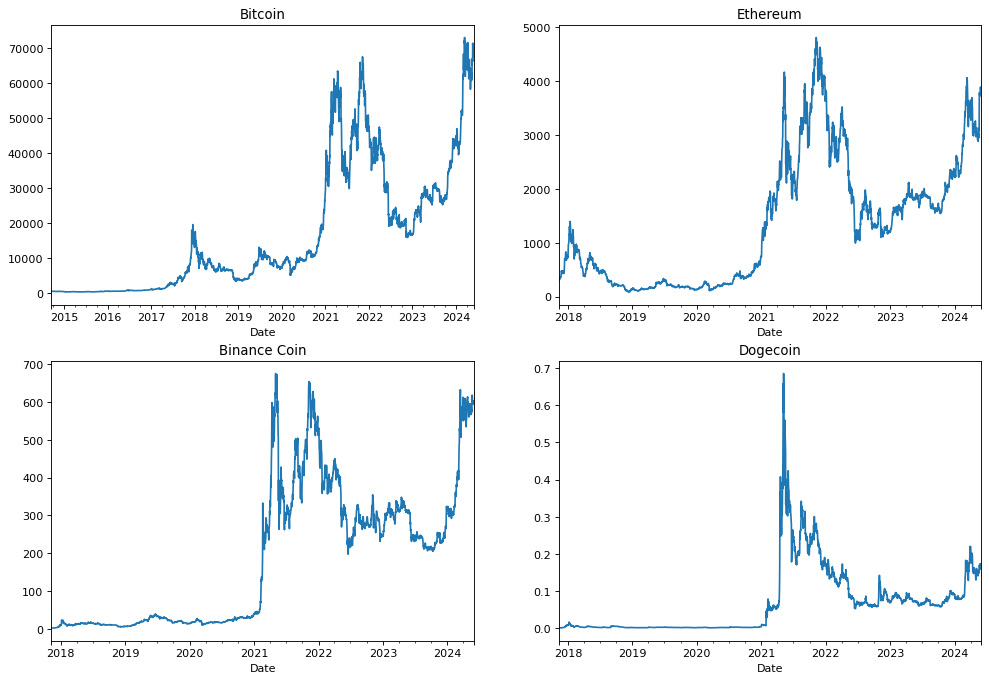

In [3]:
fig, axes = plt.subplots(figsize=(15,10), dpi=80, nrows=2, ncols=2)

for ax, name, data in zip(axes.flatten(), currency_names, currencies_data):
    data["Close"].plot(ax=ax)
    ax.set_title(name)

In [4]:
bitcoin_data = currencies_data[0]
bitcoin_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0
...,...,...,...,...,...,...,...
2024-05-28 00:00:00+00:00,69392.195312,69514.640625,67227.156250,68296.218750,32722265965,0.0,0.0
2024-05-29 00:00:00+00:00,68296.351562,68852.460938,67101.492188,67578.093750,26707072906,0.0,0.0
2024-05-30 00:00:00+00:00,67576.085938,69500.539062,67118.078125,68364.992188,29509712534,0.0,0.0


In [5]:
def RSI(data: pd.Series, window: int = 14) -> pd.Series:
    delta = data.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [6]:
past_prices_values = [1, 3, 7, 14, 30, 200]
window_values = [3, 7, 14, 30, 50, 200]

for pp in past_prices_values:
    bitcoin_data[f"{pp}D"] = bitcoin_data["Close"].shift(pp)

for window in window_values:
    # MOVING AVERAGE
    bitcoin_data[f"{window}DA"] = bitcoin_data["Close"].rolling(window=window).mean()
    # EXPONENTIAL MOVING AVERAGE
    bitcoin_data[f"{window}DEA"] = bitcoin_data["Close"].ewm(span=window, adjust=False).mean()
    # RSI
    bitcoin_data[f"{window}RSI"] = RSI(bitcoin_data["Close"].copy(), window=window)

# TARGET VARIABLE
bitcoin_data["Growth"] = (bitcoin_data["Close"] > bitcoin_data["1D"]).astype(int)

bitcoin_data

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,30DA,30DEA,30RSI,50DA,50DEA,50RSI,200DA,200DEA,200RSI,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2014-09-17 00:00:00+00:00,465.864014,468.174011,452.421997,457.334015,21056800,0.0,0.0,NaN,NaN,NaN,...,NaN,457.334015,NaN,NaN,457.334015,NaN,NaN,457.334015,NaN,0
2014-09-18 00:00:00+00:00,456.859985,456.859985,413.104004,424.440002,34483200,0.0,0.0,457.334015,NaN,NaN,...,NaN,455.211821,NaN,NaN,456.044054,NaN,NaN,457.006711,NaN,0
2014-09-19 00:00:00+00:00,424.102997,427.834991,384.532013,394.795990,37919700,0.0,0.0,424.440002,NaN,NaN,...,NaN,451.314025,NaN,NaN,453.642169,NaN,NaN,456.387699,NaN,0
2014-09-20 00:00:00+00:00,394.673004,423.295990,389.882996,408.903992,36863600,0.0,0.0,394.795990,457.334015,NaN,...,NaN,448.577894,NaN,NaN,451.887730,NaN,NaN,455.915224,NaN,1
2014-09-21 00:00:00+00:00,408.084991,412.425995,393.181000,398.821014,26580100,0.0,0.0,408.903992,424.440002,NaN,...,NaN,445.367773,NaN,NaN,449.806683,NaN,NaN,455.347123,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-05-28 00:00:00+00:00,69392.195312,69514.640625,67227.156250,68296.218750,32722265965,0.0,0.0,69394.554688,69265.945312,70136.531250,...,64809.977083,66308.312917,55.943282,64978.526250,65443.617846,47.660950,53667.061895,55156.817316,56.565002,0
2024-05-29 00:00:00+00:00,68296.351562,68852.460938,67101.492188,67578.093750,26707072906,0.0,0.0,68296.218750,68518.093750,69122.335938,...,64934.542839,66390.234261,54.286110,64947.307813,65527.322784,48.877332,53819.262109,55280.412107,56.435324,0
2024-05-30 00:00:00+00:00,67576.085938,69500.539062,67118.078125,68364.992188,29509712534,0.0,0.0,67578.093750,69394.554688,67929.562500,...,65192.147396,66517.637998,59.384132,64902.850000,65638.603937,48.385851,53975.814473,55410.606933,56.599713,1


In [7]:
bitcoin_data = bitcoin_data.dropna()
bitcoin_data.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits,1D,3D,7D,...,30DA,30DEA,30RSI,50DA,50DEA,50RSI,200DA,200DEA,200RSI,Growth
Date,,,,,,,,,,,,,,,,,,,,,
2015-04-05 00:00:00+00:00,253.761002,260.674988,251.942001,260.597992,19649200,0.0,0.0,253.697006,253.005005,242.712997,...,265.654567,257.536366,46.401498,259.639901,258.807999,50.561944,309.859490,306.873610,44.397749,1
2015-04-06 00:00:00+00:00,260.721008,261.798004,254.574997,255.492004,20034200,0.0,0.0,260.597992,254.322006,247.526001,...,264.962268,257.404472,43.892944,260.053241,258.677960,53.768809,309.014750,306.362350,45.111678,0
2015-04-07 00:00:00+00:00,255.274002,255.804993,252.205002,253.179993,18467400,0.0,0.0,255.492004,253.697006,244.223999,...,264.256468,257.131925,43.788641,260.439981,258.462354,53.509247,308.306670,305.833173,45.836650,0
2015-04-08 00:00:00+00:00,253.063995,253.847000,244.214996,245.022003,30086400,0.0,0.0,253.179993,260.597992,247.272003,...,262.770301,256.350639,36.353000,260.468221,257.935281,50.257753,307.487260,305.228086,45.165140,0
2015-04-09 00:00:00+00:00,244.751007,246.117996,239.399994,243.675995,21643500,0.0,0.0,245.022003,255.492004,253.005005,...,261.167501,255.532920,35.208913,260.615221,257.376093,51.371431,306.711535,304.615628,45.399181,0


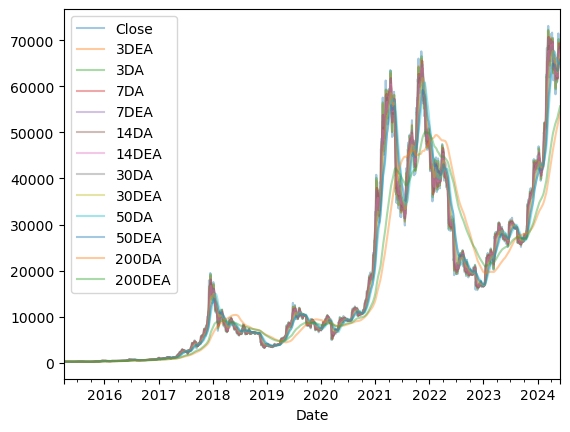

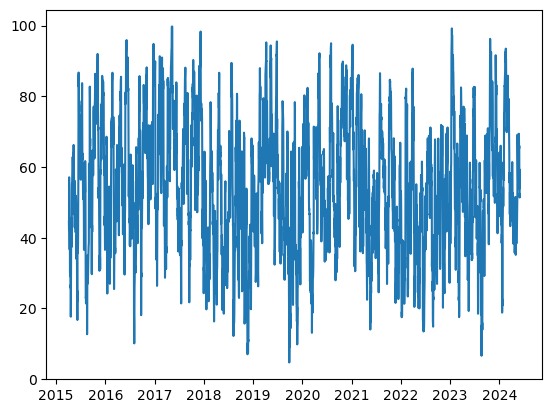

In [22]:
bitcoin_data[["Close", "3DEA", "3DA", "7DA", "7DEA", "14DA", "14DEA", "30DA", "30DEA", "50DA", "50DEA", "200DA", "200DEA"]].plot(alpha=0.4)
plt.show()

plt.plot(bitcoin_data["14RSI"])

In [30]:
features = ["Open", "High", "Low", "Close", "Volume",
            "1D", "3D", "7D", "14D", "30D", "200D",
            "3DA", "7DA", "14DA", "30DA", "50DA", "200DA",
            "3DEA", "7DEA", "14DEA", "30DEA", "50DEA", "200DEA",
            "3RSI", "7RSI", "14RSI", "30RSI", "50RSI", "200RSI"]

def check_model(model, data: pd.DataFrame, features: list, target: str, test_size: int = 300):
    X = bitcoin_data[features].values
    y = bitcoin_data[target].values

    n_size = len(X)

    # Train Test Split
    X_train = X[:n_size-test_size, :]
    X_test = X[n_size-test_size:, :]
    
    y_train = y[:n_size-test_size]
    y_test = y[n_size-test_size:]

    # Fitting the model
    model.fit(X_train, y_train)

    # Predicting with a threshold
    y_pred = model.predict_proba(X_test)[:,1]
    y_pred[y_pred > 0.6] = 1
    y_pred[y_pred <= 0.6] = 0

    # Displaying the results
    print(classification_report(y_test, y_pred))

    ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred)).plot()
    plt.show()


              precision    recall  f1-score   support

           0       0.59      0.89      0.71       143
           1       0.81      0.43      0.56       157

    accuracy                           0.65       300
   macro avg       0.70      0.66      0.64       300
weighted avg       0.70      0.65      0.63       300



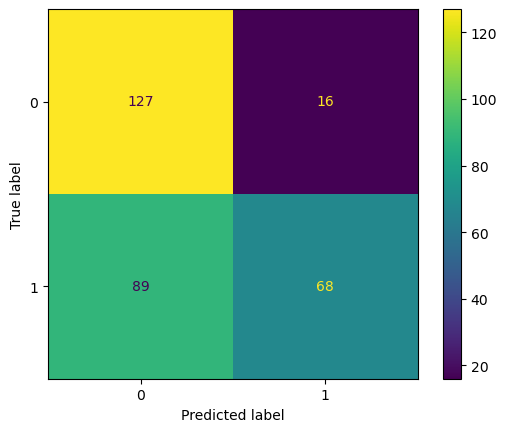

In [76]:
rf = RandomForestClassifier(bootstrap=False)

check_model(rf, bitcoin_data, features, "Growth")

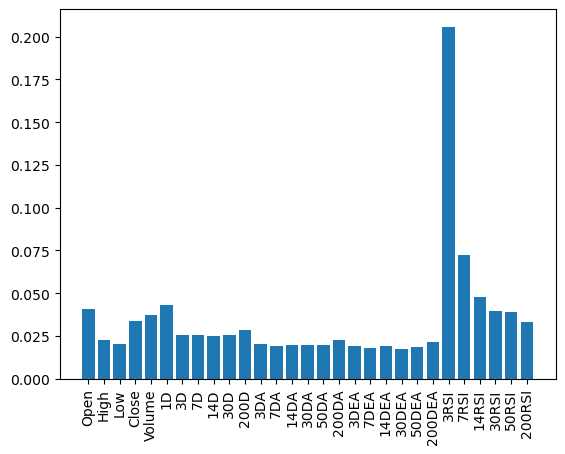

In [46]:
plt.bar(range(1, len(features)+1), rf.feature_importances_)
plt.xticks(range(1, len(features)+1), features)
plt.xticks(rotation=90)
plt.show()

In [52]:
rfe = RFE(RandomForestClassifier())
rfe.fit(bitcoin_data[features], bitcoin_data["Growth"])

RFE(estimator=RandomForestClassifier())

In [59]:
features_rfe = list(np.array(features)[rfe.ranking_ == 1])

              precision    recall  f1-score   support

           0       0.56      0.93      0.70       143
           1       0.84      0.34      0.48       157

    accuracy                           0.62       300
   macro avg       0.70      0.63      0.59       300
weighted avg       0.71      0.62      0.59       300



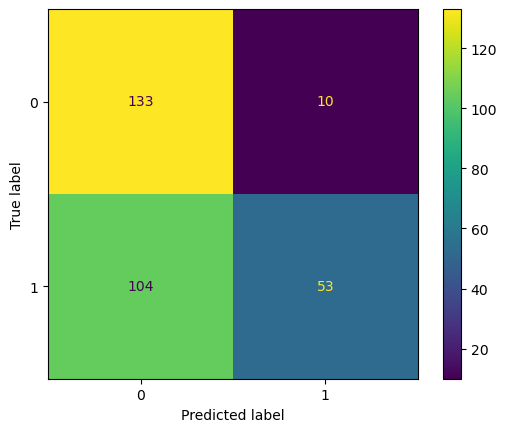

In [62]:
features_cut = ["Open", "Close", "Volume", "1D", "30D", "200DA", "200DEA", "3RSI", "7RSI", "14RSI", "30RSI", "50RSI", "200RSI"]

rf_cut = RandomForestClassifier()
check_model(rf_cut, bitcoin_data, features_rfe, "Growth")

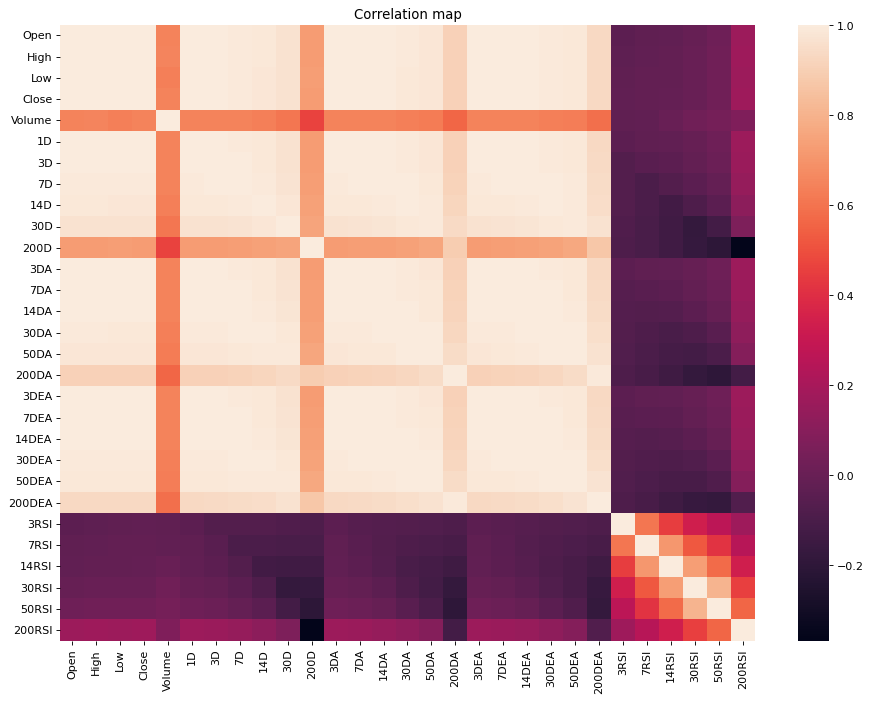

In [35]:
plt.figure(figsize=(14,10), dpi=80)
sns.heatmap(bitcoin_data[features].corr())
plt.title("Correlation map")
plt.show()

In [172]:
splitter = TimeSeriesSplit(n_splits=5)

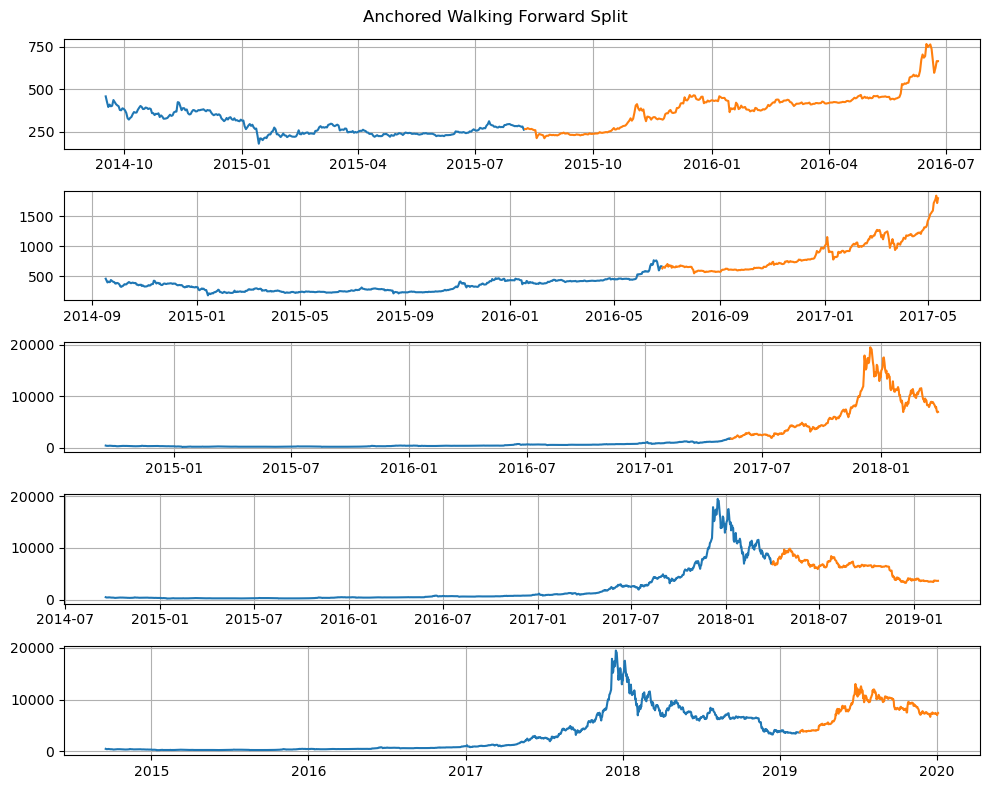

In [241]:
fig, axes = plt.subplots(figsize=(10, 8), nrows=5)

for ax, (x_s, t_s) in zip(axes.flatten(), splitter.split(bitcoin_data)):
    data_part_train = bitcoin_data.iloc[x_s, :]
    data_part_test = bitcoin_data.iloc[t_s, :]
    ax.plot(data_part_train["Close"])
    ax.plot(data_part_test["Close"])
    ax.grid()
fig.suptitle("Anchored Walking Forward Split")
plt.tight_layout()

In [66]:
def prediction_scorer_threshold(model, X: np.array, y: np.array, threshold: float = 0.6, scoring=precision_score) -> float:
    """
    Calculates the given metric, classifing the class 1 under the condition of exceeding the given probability threshold..
    """
    y_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_prob > threshold).astype(int)

    return scoring(y, y_pred, pos_label=1, zero_division=np.nan)
    

def check_model_awf(model, X: np.array, y: np.array, splits: int = 5) -> float:
    """
    Cross-validates the Time Series data with Anchored Walking Forward approach.
    """
    cvts = TimeSeriesSplit(n_splits=splits)
    return np.mean(cross_val_score(model, X, y, cv=cvts, scoring=prediction_scorer_threshold))


def check_model_rwf(model, X: np.array, y: np.array, max_train_size: int = 500, test_size: int = 100) -> float:
    """
    Cross-validates the Time Series data with Rolling Walking Forward approach.
    """
    splits = (len(X)-max_train_size)//test_size
    cvts = TimeSeriesSplit(n_splits=splits, max_train_size=max_train_size, test_size=test_size)
    return np.nanmean(cross_val_score(model, X, y, cv=cvts, scoring=prediction_scorer_threshold))

In [71]:
Xf = bitcoin_data[features].values
yf = bitcoin_data["Growth"].values

Xfc = bitcoin_data[features_cut].values
yfc = bitcoin_data["Growth"].values

Xfr = bitcoin_data[features_rfe].values
yfr = bitcoin_data["Growth"].values

In [77]:
titles = ["All features", "Features picked by rf importances", "Features picked by RFE"]
for name, (X, y) in zip(titles, [(Xf, yf), (Xfc, yfc), (Xfr, yfr)]):
    print(f"--- --- --- --- --- --- {name} --- --- --- --- --- ---")
    print("--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---")
    print(check_model_awf(rf, Xf, yf, splits=10))
    print("--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---")
    print(check_model_rwf(rf, Xf, yf))
    print("\n\n\n")

--- --- --- --- --- --- All features --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
0.8352205883378716
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
0.7960828316751015




--- --- --- --- --- --- Features picked by rf importances --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
0.8330433522095669
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
0.8035140069341534




--- --- --- --- --- --- Features picked by RFE --- --- --- --- --- ---
--- --- --- Raw Random Forest Anchored Walking Forward Cross-validation Score --- --- ---
0.8452362720482229
--- --- --- Raw Random Forest Rolling Walking Forward Cross-validation Score --- --- ---
0.8073595114466302






# ToDo
1. ARIMA
2. Cross-validation with different approaches
3. LSTM
4. Various ML algorythms
---
5. River - online learning

# Feature Selection

1. Recursive Feature Elimination (RFE)
2. Feature Importance from (Random Forest, Gradient Boosting)
3. Lasso Regression

# Cross-validation

1. TimeSeriesSplit Validation
2. Walk Forward validation:
   1. Increasing training size
   2. Fixed training size

In [195]:
bitcoin_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3546 entries, 2014-09-17 00:00:00+00:00 to 2024-06-01 00:00:00+00:00
Data columns (total 32 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          3546 non-null   float64
 1   High          3546 non-null   float64
 2   Low           3546 non-null   float64
 3   Close         3546 non-null   float64
 4   Volume        3546 non-null   int64  
 5   Dividends     3546 non-null   float64
 6   Stock Splits  3546 non-null   float64
 7   1D            3545 non-null   float64
 8   3D            3543 non-null   float64
 9   7D            3539 non-null   float64
 10  14D           3532 non-null   float64
 11  30D           3516 non-null   float64
 12  200D          3346 non-null   float64
 13  3DA           3544 non-null   float64
 14  3DEA          3546 non-null   float64
 15  3RSI          3544 non-null   float64
 16  7DA           3540 non-null   float64
 17  7DEA          3546 non-